### INTRODUCTION: 

The visualization for this notebook uses Lonboard, which is a new Python library for fast, interactive geospatial vector data visualization for big raster or vector files in Jupyter. By utilizing new tools like GeoArrow and GeoParquet in conjunction with GPU-based map rendering, lonboard aims to enable visualizing large geospatial datasets interactively through a simple interface. 

CODE PREPARED BY:

*-- Paromita Basak, University of Maryland College Park*

CODE SUPPORTED BY: 

*-- Dr. Rajat Shinde, NASA IMPACT*

*-- Dr. Alex I. Mandel, Development Seed*

*-- Dr. Neha Hunka, University of Maryland College Park*

*-- Dr. Laura Duncanson, University of Maryland College Park

**Support via a GEDI Science Team grant, PI Dr. Laura Duncanson, and the NASA MAAP User Working Group**

Importing Packages¶
We import the required packages for this tutorial.

This notebook is designed to run on the NASA MAAP in a "Pangeo" workspace. To prepare your workspace, install packages via the terminal and restart the kernel in this notebook with:
conda env update -f /projects/shared-buckets/minord/biomass_reference_maps/env/lonboard-env.yml --prune

1. Creating executed notebook
python -m nbconvert /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Cambodia/Cambodia_GEDI_explore_PART2.ipynb --to ipynb --stdout --execute > /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Cambodia/Cambodia_GEDI_explore_PART2_executed.ipynb

2. Create shared notebook
pip install nbss-upload

nbss-upload /projects/ADE_biomass_harmonization/NASA_CMS/NASA_CMS_2023/Cambodia/Cambodia_GEDI_explore_PART2_executed.ipynb

In [1]:
#load packages to run scripts
import geopandas as gpd
from lonboard import viz
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer, PolygonLayer, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize
import httpx

## Part 2: Compare multiple biomass maps (GEDI, CCI) and Cambodian Field Data


**Adding NFI Data**

In this first section we visualize Cambodia's National Forest Inventory(NFI) data over Mondulkiri Srepok National Park.

In [2]:
##Define NFI file path
path = "/projects/shared-buckets/nehajo88/Data/NASA_CMS_2023/CAMBODIA/KHM_AGBD.gpkg"

In [3]:
#Read file using geopandas and pyogrio
NFI_gdf = gpd.read_file(path, engine="pyogrio")

In [4]:
#Create a scatter plot layer from a GeoPandas DataFrame (NFI_gdf) and adds it to a map
NFI_layer = ScatterplotLayer.from_geopandas(NFI_gdf)
m = Map(layers=[NFI_layer])

/opt/conda/envs/pangeo/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [5]:
##Sets the fill color of the GEDI_original_layer scatter plot to a specific RGB color value [200, 100, 100].
NFI_layer.get_fill_color = [200, 100, 100]

In [6]:
#Prints the file head for seeing column names which will be needed in next step
NFI_gdf.head()

,X1..Cluster.Number,X_CEN,Y_CEN,AGBD_Kg_Cluster,AGBD.PLOT,geometry
0,95293,X,Y,8544.866404,18.988592,POINT (729338.000 1471740.000)
1,95305,X,Y,0.000000,0.000000,POINT (741338.500 1471790.500)
2,95311,X,Y,1870.999682,4.157777,POINT (747340.000 1471741.000)
3,95317,X,Y,24234.573531,53.854608,POINT (753337.000 1471741.000)
4,95329,X,Y,9496.647798,21.103662,POINT (765337.000 1471741.000)


In [7]:
#Display the map
m= Map(layers=[NFI_layer])
m

Map(layers=[ScatterplotLayer(get_fill_color=[200, 100, 100], table=pyarrow.Table
X1..Cluster.Number: uint32
X_…

Now, we would like to plot data based on a statistic. Let's plot based on the value of the 'AGBD.PLOT' column. We will use a linear colormap excluding the lowest and highest 10 percentiles of the data.

First, we'll find what the values of the 10th and 90th percentile are:

In [8]:
#Calculate the 10th percentile (q10) and the 90th percentile (q90) of the 'agbd' column in the gedi_gdf GeoPandas DataFrame.
q10 = NFI_gdf['AGBD.PLOT'].quantile(.1)
q90 = NFI_gdf['AGBD.PLOT'].quantile(.9)

Then we can construct a "normalizer" based on Normalize that will do linear rescaling between the two values we supply:

In [9]:
normalizer = mpl.colors.Normalize(q10, q90)

Calling this normalizer on our data will return a scaled version ranging between 0 and 1:

In [10]:
normalized_agbd = normalizer(NFI_gdf['AGBD.PLOT'])
normalized_agbd

masked_array(data=[1.06805102e-01, 0.00000000e+00, 2.33862418e-02,
                   3.02915923e-01, 1.18701731e-01, 9.21886933e-02,
                   0.00000000e+00, 4.89534950e-02, 8.41044797e-01,
                   5.48547557e-01, 2.25573421e-01, 2.10265112e-01,
                   4.59945844e-02, 1.11440742e-01, 1.16798183e-03,
                   3.15464584e+00, 7.58921943e-01, 6.98165067e-03,
                   2.99925464e-01, 2.95204391e-01, 1.67591965e-01,
                   0.00000000e+00, 0.00000000e+00, 4.06929019e-01,
                   1.45924167e-02, 9.14915726e-02, 5.87015606e-01,
                   1.03598782e+00, 5.10558737e-01, 0.00000000e+00,
                   1.29452236e-01, 7.44905237e-02, 5.66428009e-01,
                   5.11196919e-01, 1.77135935e-01, 2.66022486e-01,
                   4.31812977e+00, 0.00000000e+00, 5.87069417e-01,
                   5.38203124e+00, 9.84949269e-01, 4.27302503e-01,
                   3.56465597e-01, 5.12055663e+00, 0.00000000e

Here we construct color values by taking a Matplotlib colormap and calling it on our normalized values. Ensure you use bytes=True when calling the colormap object so that the output colors range from 0-255 and not 0-1.

In [11]:
# Ensure lengths match
if len(normalized_agbd) == len(NFI_gdf):
    # Apply the viridis colormap
    viridis_colormap = plt.get_cmap("viridis")
    colors = viridis_colormap(normalized_agbd, bytes=True)
    NFI_layer.get_fill_color = colors
    NFI_layer.radius_min_pixels = 5
else:
    raise ValueError("normalized_agbd length does not match the length of Improved_gedi_gdf")

The map should now have updated to show points colored by their agbd value. To remind ourselves what the high and low values are, we can inspect the colormap object itself:

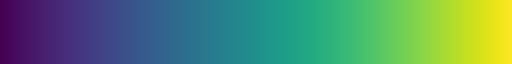

In [12]:
viridis_colormap

For showing the plots against a basemap, here we call upon a basemap from ESRI which can be used on lonboard visualization of the plots.

In [13]:
ESRI_basemap = BitmapTileLayer(
    data="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tile_size=256,
    max_requests=-1,
    min_zoom=0,
    max_zoom=19,
)
m = Map(ESRI_basemap)

In [14]:
m = Map([ESRI_basemap,NFI_layer])
m

Map(layers=[BitmapTileLayer(data='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServ…

**CCI Biomass Layer**

The ESA's Climate Change Initiative (CCI) Biomass project aimed to produce global maps of above-ground biomass for 2010, 2017, and 2018 to quantify biomass changes. The mapping is done with a 100-meter grid spacing, aiming for a relative error of less than 20 percent in areas where the above-ground biomass (AGB) exceeds 50 Mg ha-1. 

For visualizing the CCI Biomass layer, we will use BitmapTileLayer which renders tiles dynamically generated by TiTiler.

In [15]:
titiler_endpoint = "https://titiler.maap-project.org"

In [16]:
CCI_product_url = "s3://maap-ops-workspace/shared/pbasak/Cambodia_Notebook/CCI_AOImasked.tif"

In [17]:
CCI_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/pbasak/Cambodia_Notebook/CCI_AOImasked.tif&rescale=0,60&colormap_name=viridis"

In [18]:
r_CCI = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": CCI_product_url,
    }
).json()

bounds_CCI = r_CCI["bounds"]
print(bounds_CCI)

[106.98488888881904, 12.66844444451776, 107.6088888888128, 13.36711111117744]


In [19]:
CCI_product_layer = BitmapTileLayer(
    data=CCI_product_tile_url,
    tile_size=148,
    max_requests=-1,
    extent=bounds_CCI
)

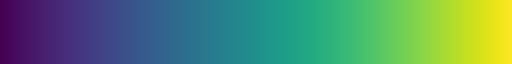

In [20]:
viridis_colormap